<a href="https://colab.research.google.com/github/ShishirSinha/Grocery_List_App/blob/master/Major_project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle/amazon_review

/content/gdrive/My Drive/Kaggle/amazon_review


In [3]:
# import the libraries

import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
import nltk
nltk.download('stopwords')
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Custom attention later 

class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [5]:
# Load the dataset
data=pd.read_csv("/content/gdrive/MyDrive/Kaggle/amazon_review/Reviews_neg.csv")

In [6]:
# Data Preprocessing phase begins

data.drop_duplicates(subset=['Text'],inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)  #dropping na

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8919 entries, 0 to 12653
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  8919 non-null   int64 
 1   Summary     8919 non-null   object
 2   Text        8919 non-null   object
dtypes: int64(1), object(2)
memory usage: 278.7+ KB


In [8]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [9]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                        #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [10]:
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0))

In [11]:
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [12]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [13]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

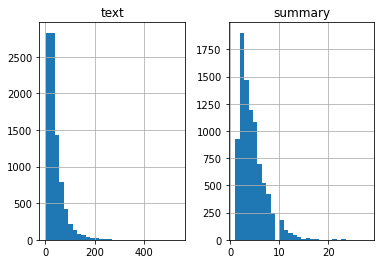

In [14]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [15]:
cnt=0
for i in data['cleaned_text']:
    if(len(i.split())<=30):
        cnt=cnt+1
print('% of reviews with length <= 30  :  ', cnt/len(data['cleaned_text'])*100)

% of reviews with length <= 30  :   51.70983294091266


In [16]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=8):
        cnt=cnt+1
print('% of summaries with length <= 8  :  ', cnt/len(data['cleaned_summary'])*100)

% of summaries with length <= 8  :   92.10673842359009


In [17]:
max_text_len=30
max_summary_len=8

In [18]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [19]:
print(df['text'])

0                                                              love eating good watching tv looking movies sweet like transfer zip lock baggie stay fresh take time eating
1                                                                   bag candy online pretty expensive cheaper order compete grocery stores good combination favorite candy
2                                                                                                                                        arrived days stale could eat bags
3                                                                                  fed golden retriever hated would eat gave terrible diarrhea buying also super expensive
4                                            bought grocery outlet seattle tacoma case tweleve paying yes dollar like taste great bad either low calorie buy whacked price
                                                                                       ...                                                       

In [20]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [21]:
print(df['summary'])

0                                       sostok poor taste eostok
1                                 sostok pretty expensive eostok
2                                    sostok stale product eostok
3                                              sostok bad eostok
4                             sostok never paid that much eostok
                                  ...                           
4403    sostok ugh am never going to buy proflowers again eostok
4404                           sostok expensive and bland eostok
4405                      sostok horrible smell and taste eostok
4406             sostok having bad day it just got better eostok
4407                                sostok horrible taste eostok
Name: summary, Length: 4408, dtype: object


In [22]:
# Split the dataset into training dataset and validation dataset
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)

In [23]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [24]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

In [25]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [26]:
print(x_tr[:5])

[[ 354   12  508  251  211  493  890 1725   84  471  103   81    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 203   27    5   26   21   53   41   81   14 1154 1726  379 1258  937
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 102    6   63   66 1155 1985  538   32  938   17  494  132  122  203
  1727 1986  330  422  187   81   14    0    0    0    0    0    0    0
     0    0]
 [   1   21   62  612 1259   65  111 1156   15   11  380   51  714 1728
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 115    1 1395  311    5  290  144 1073   24  284    1  381  445   63
  1729 1074    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]


In [27]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [28]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

In [29]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary ( +1 for padding token)
y_voc  =   y_tokenizer.num_words +1

In [30]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [31]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [32]:
# Model Building Phase begins

K.clear_session()

latent_dim = 300
embedding_dim = 200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb_layer =  Embedding(x_voc, embedding_dim,trainable=True)
enc_emb = enc_emb_layer(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# #encoder lstm 22
# encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
# encoder_output22, state_h22, state_c22 = encoder_lstm2(encoder_output2)

#encoder lstm 3
encoder_lstm3 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 200)      468200      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 30, 300), (N 601200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [33]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=["accuracy"])

In [34]:
history = model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:], epochs=10, batch_size=64, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/10
62/62 [==============================] - 36s 387ms/step - loss: 2.8951 - accuracy: 0.4723 - val_loss: 1.8682 - val_accuracy: 0.6273
Epoch 2/10
62/62 [==============================] - 23s 365ms/step - loss: 1.9091 - accuracy: 0.6287 - val_loss: 1.6734 - val_accuracy: 0.6643
Epoch 3/10
62/62 [==============================] - 23s 368ms/step - loss: 1.7104 - accuracy: 0.6537 - val_loss: 1.5204 - val_accuracy: 0.6828
Epoch 4/10
62/62 [==============================] - 23s 368ms/step - loss: 1.5481 - accuracy: 0.6775 - val_loss: 1.4387 - val_accuracy: 0.6942
Epoch 5/10
62/62 [==============================] - 23s 370ms/step - loss: 1.4689 - accuracy: 0.6895 - val_loss: 1.3976 - val_accuracy: 0.7058
Epoch 6/10
62/62 [==============================] - 23s 366ms/step - loss: 1.3935 - accuracy: 0.7035 - val_loss: 1.3506 - val_accuracy: 0.7195
Epoch 7/10
62/62 [==============================] - 23s 371ms/step - loss: 1.3536 - accuracy: 0.7037 - val_loss: 1.3162 - val_accuracy: 0.7159

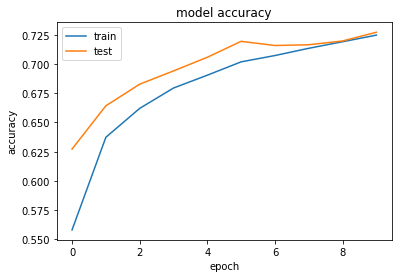

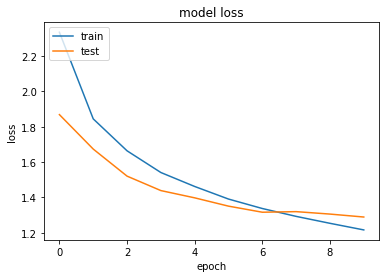

In [35]:
# Visualize training

# Summarize the history of accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize the history of loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [37]:
# encoder inference
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [38]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [39]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [40]:
data1=pd.read_csv("/content/gdrive/MyDrive/Kaggle/amazon_review/Reviews_neg.csv")
for i in range(0, 10):
    uinp = data1['Text'][i]
    cleaned_inp = []
    cleaned_inp.append(text_cleaner(uinp,0))
    inp_seq = x_tokenizer.texts_to_sequences(cleaned_inp)
    inp = pad_sequences(inp_seq, maxlen=max_text_len, padding='post')
    
    print(i, "Review:", uinp)
    print("\tReference summary : ", data1['Summary'][i])
    print("\tPredicted summary: ",decode_sequence(inp[0].reshape(1,max_text_len)))
    print("\n")


0 Review: I love eating them and they are good for watching TV and looking at movies! It is not too sweet. I like to transfer them to a zip lock baggie so they stay fresh so I can take my time eating them.
	Reference summary :  poor taste
	Predicted summary:   poor quality


1 Review: This bag of candy online is pretty expensive, it should be cheaper in order to compete with grocery stores, other than that, its a good combination of my favorite candy
	Reference summary :  pretty expensive
	Predicted summary:   overpriced


2 Review: Arrived in 6 days and were so stale i could not eat any of the 6 bags!!
	Reference summary :  stale product.
	Predicted summary:   stale


3 Review: I fed this to my Golden Retriever and he hated it.  He wouldn't eat it, and when he did, it gave him terrible diarrhea.  We will not be buying this again.  It's also super expensive.
	Reference summary :  Bad
	Predicted summary:   bad


4 Review: I bought these at Grocery Outlet here in the Seattle Tacoma are f

In [41]:
!pip install git+https://github.com/tagucci/pythonrouge.git
!apt-get install -y cpanminus
!cpanm --force XML::Parser

  Cloning https://github.com/tagucci/pythonrouge.git to /tmp/pip-req-build-v7mssxtc
  Running command git clone -q https://github.com/tagucci/pythonrouge.git /tmp/pip-req-build-v7mssxtc
  Created wheel for pythonrouge: filename=pythonrouge-0.2-cp37-none-any.whl size=285401 sha256=1bb8fc911226aee02fb6ca1efb7f99736a7debc70e26b78977d5dd7781353788
  Stored in directory: /tmp/pip-ephem-wheel-cache-bei725bo/wheels/fd/ff/be/6716935d513fa8656ab185cb0aa70aed382b72dda42bf09c95
Successfully built pythonrouge
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libalgorithm-c3-perl libb-hooks-endofscope-perl libb-hooks-op-check-perl
  libclass-c3-perl libclass-c3-xs-perl libclass-method-modifiers-perl
  libclass-xsaccessor-perl libcpan-changes-perl libcpan-distnameinfo

In [42]:
from pythonrouge.pythonrouge import Pythonrouge

rouge_1_sum = 0
rouge_2_sum = 0
rouge_L_sum = 0

for i in range(100):
    original_string = seq2summary(y_val[i])
    predicted_string = decode_sequence(x_val[i].reshape(1,max_text_len))

    # system summary(predict) & reference summary
    summary = [[predicted_string]]
    reference = [[[original_string]]]

    # initialize setting of ROUGE to eval ROUGE-1, 2, SU4
    # if you evaluate ROUGE by sentence list as above, set summary_file_exist=False
    # if recall_only=True, you can get recall scores of ROUGE
    rouge = Pythonrouge(summary_file_exist=False,
                        summary=summary, reference=reference,
                        n_gram=2, ROUGE_SU4=False, ROUGE_L=True,
                        recall_only=True, stemming=True, stopwords=True,
                        word_level=True, length_limit=True, length=50,
                        use_cf=False, cf=95, scoring_formula='average',
                        resampling=True, samples=1000, favor=True, p=0.5)
    score = rouge.calc_score()
    rouge_1_sum = rouge_1_sum + score['ROUGE-1']
    rouge_2_sum = rouge_2_sum + score['ROUGE-2']
    rouge_L_sum = rouge_L_sum + score['ROUGE-L']

print("\nROUGE-1 : ", rouge_1_sum/100, "  ROUGE-2 : ", rouge_2_sum/100, "  ROUGE-L : ", rouge_L_sum/100, "  Accuracy : ", max(history.history['val_accuracy']))


ROUGE-1 :  0.2966666   ROUGE-2 :  0.025   ROUGE-L :  0.2966666   Accuracy :  0.7272727489471436


In [43]:
!pip install colabcode

     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 8.3MB 34.5MB/s 
     |████████████████████████████████| 747kB 42.6MB/s 
     |████████████████████████████████| 61kB 10.8MB/s 
     |████████████████████████████████| 430kB 45.2MB/s 
     |████████████████████████████████| 389kB 46.1MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 81kB 12.5MB/s 
     |████████████████████████████████| 71kB 11.5MB/s 
     |████████████████████████████████| 122kB 58.9MB/s 
     |████████████████████████████████| 61kB 11.3MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.0.5-cp37-none-any.whl size=19246 sha256=d31dea81af69564056497cc0b1b5549c55087ce2d600f4c2e9b0715933510456
  Stored in directory: /root/.cache/pip/wheels/0c/13/64/5ebbcc22eaf53fdf5766b397c1fb17c83f5775fdccf0ea1b88
Successfully built pyngrok
ERROR: google-colab 1.0.0 has requirement tornado~=5.1.0; python_version >= "3.0", but you'll have tornad

In [44]:
!pip install fastapi

     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 
     |████████████████████████████████| 10.1MB 40.8MB/s 


In [45]:
from pydantic import BaseModel

class TextClass(BaseModel):
    inp_text: str
    class Config:
        schema_extra = {
            "example": {
                "inp_text": "The food is good. I like it."
            }
        }

In [46]:
from fastapi import FastAPI
from fastapi.responses import HTMLResponse

app = FastAPI()

@app.on_event("startup")
def load_model():
    print('Started.!!')

@app.get('/')
def index():
    return {'message' : 'Welcome to our project : Automatic Text Summarizer demo'}


@app.post('/predict')
def get_summary(data: TextClass):
    received = data.dict()
    uinp = received['inp_text']
    
    cleaned_inp = []
    cleaned_inp.append(text_cleaner(uinp,0))
    
    inp_seq = x_tokenizer.texts_to_sequences(cleaned_inp)
    inp = pad_sequences(inp_seq, maxlen=max_text_len, padding='post')
    
    pred_name = decode_sequence(inp[0].reshape(1,max_text_len))

    return {'prediction' : pred_name}

In [47]:
from colabcode import ColabCode
server = ColabCode(port=10000, code=False)

In [ ]:
server.run_app(app=app)

Public URL: NgrokTunnel: "http://71e47272c94e.ngrok.io" -> "http://localhost:10000"
